In [69]:
import pyspark as ps
import pandas as pd
from scipy import sparse
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.ml.recommendation import ALS
import numpy as np
import matplotlib.pyplot as plt


In [5]:
spark = SparkSession.builder.getOrCreate()

In [21]:
ratings_df = pd.read_csv('/home/jovyan/work/Documents/Galvanize/CaseStudies/recommender-case-study/\
data/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('/home/jovyan/work/Documents/Galvanize/CaseStudies/recommender-case-study/\
data/ml-latest-small/movies.csv')
tags_df = pd.read_csv('/home/jovyan/work/Documents/Galvanize/CaseStudies/recommender-case-study/\
data/ml-latest-small/tags.csv')
links_df = pd.read_csv('/home/jovyan/work/Documents/Galvanize/CaseStudies/recommender-case-study/\
data/ml-latest-small/links.csv')


In [27]:
# Merge ratings with movies
ratings_df.drop(columns='timestamp', inplace=True)
ratings_movies_merge = ratings_df.merge(movies_df, how='left', on='movieId')

In [68]:
ratings_movies_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


In [29]:
print(ratings_movies_merge.head())

   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [30]:
spark_df_ratings_movies = spark.createDataFrame(ratings_movies_merge)

train, test = spark_df_ratings_movies.randomSplit([0.8,0.2], seed=142)

als_model = ALS(itemCol='movieId',
                userCol='userId',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10)

recommender = als_model.fit(train)

In [31]:
predictions = recommender.transform(test)

In [62]:
train_df = train.toPandas()
predictions_df = predictions.toPandas()
predictions_df.fillna(train_df['rating'].mean(), inplace=True)
print(predictions_df.head())

   userId  movieId  rating                        title  genres  prediction
0     133      471     4.0  Hudsucker Proxy, The (1994)  Comedy    2.820126
1     602      471     4.0  Hudsucker Proxy, The (1994)  Comedy    3.320655
2     182      471     4.5  Hudsucker Proxy, The (1994)  Comedy    3.291657
3      32      471     3.0  Hudsucker Proxy, The (1994)  Comedy    3.379117
4     426      471     5.0  Hudsucker Proxy, The (1994)  Comedy    2.240917


In [63]:
print(predictions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20326 entries, 0 to 20325
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userId      20326 non-null  int64  
 1   movieId     20326 non-null  int64  
 2   rating      20326 non-null  float64
 3   title       20326 non-null  object 
 4   genres      20326 non-null  object 
 5   prediction  20326 non-null  float32
dtypes: float32(1), float64(1), int64(2), object(2)
memory usage: 873.5+ KB
None


In [64]:
predictions_df['MSE'] = (predictions_df['rating']-predictions_df['prediction'])**2
predictions_df['RMSE'] = (predictions_df['MSE'])**0.5
print(predictions_df.head())
print(predictions_df.info())

   userId  movieId  rating                        title  genres  prediction  \
0     133      471     4.0  Hudsucker Proxy, The (1994)  Comedy    2.820126   
1     602      471     4.0  Hudsucker Proxy, The (1994)  Comedy    3.320655   
2     182      471     4.5  Hudsucker Proxy, The (1994)  Comedy    3.291657   
3      32      471     3.0  Hudsucker Proxy, The (1994)  Comedy    3.379117   
4     426      471     5.0  Hudsucker Proxy, The (1994)  Comedy    2.240917   

        MSE      RMSE  
0  1.392104  1.179874  
1  0.461510  0.679345  
2  1.460093  1.208343  
3  0.143729  0.379117  
4  7.612540  2.759083  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20326 entries, 0 to 20325
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userId      20326 non-null  int64  
 1   movieId     20326 non-null  int64  
 2   rating      20326 non-null  float64
 3   title       20326 non-null  object 
 4   genres      20326 non-

In [66]:
RMSE_tot = predictions_df['RMSE'].sum()
RMSE_count = predictions_df['RMSE'].shape[0]
print(RMSE_count)

RMSE = RMSE_tot/RMSE_count
print(RMSE)

20326
0.6880513920428468


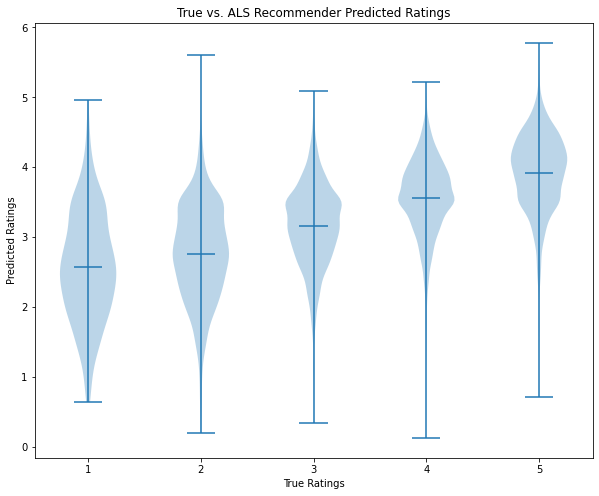

In [73]:
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,8))
ax.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.savefig('/home/jovyan/work/Documents/Galvanize/\
CaseStudies/recommender-case-study/images/ALS_violin_plt.png')
plt.show()